<a href="https://colab.research.google.com/github/ManDes71/Rakuten_Text_Classification_ML/blob/main/notebooks/Modele_arbre_decision%20Tfidf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

a***Google Colab -> Cette cellule est à executer (1 fois) pour le cloner le dépot en local***  
il est possible que google colab vous demande re demarrer la session

In [ ]:
!git clone https://github.com/ManDes71/Rakuten_Text_Classification_ML.git


***Google Colab -> Cette cellule est à executer (2 fois) pour installer les bibliothèques nécessaires***  
You must restart the runtime in order to use newly installed versions

In [ ]:
import sys
sys.path.append('/content/Rakuten_Text_Classification_ML/src')

!pip install -r /content/Rakuten_Text_Classification_ML/requirements.txt

In [ ]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize.regexp import RegexpTokenizer
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn import model_selection
from sklearn.metrics import f1_score, make_scorer

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
# set the max columns to none
pd.set_option('display.max_columns', None)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\shaky\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shaky\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
import configparser
import sys
sys.path.append('../src')
#sys.path.append('/content/Rakuten_Text_Classification_ML/src')
import Bibli_DataScience_3_1 as ds
config = configparser.ConfigParser()
config.read('Rakuten_config_colab.ini')

section :  ['DOSSIER', 'FICHIER']


[]

In [ ]:
import pandas as pd

# lecture des données sources d'entrainement
df_feats=pd.read_csv(ds.get_RACINE_DOSSIER() + 'X_train_update.csv')

# lecture des données cibles d'entrainement
df_target=pd.read_csv(ds.get_RACINE_DOSSIER() + 'Y_train_CVw08PX.csv')


# création d'un dataframe globale -  jointure
df=df_feats.merge(df_target,on='Unnamed: 0',how='inner')
df.rename(columns={'Unnamed: 0': 'Id'}, inplace=True)

# récupération du fichier df_langue.csv
df_langue=pd.read_csv(ds.get_RACINE_DOSSIER() + 'df_langue.csv')
df=df.merge(df_langue.drop(['Unnamed: 0','prdtypecode'], axis=1),on='Id',how='inner')
df_feats['PAYS_LANGUE'] = df['PAYS_LANGUE']


Lcat=df_target.sort_values(by='prdtypecode')['prdtypecode'].unique()


nomenclature=pd.read_csv(ds.get_RACINE_DOSSIER() + 'NOMENCLATURE.csv',header=0,encoding='utf-8',sep=';',index_col=0)
catdict=nomenclature.to_dict()['definition']

#
stopwordFR = pd.read_csv(ds.get_RACINE_DOSSIER() + 'stopwords_FR_02.csv')
stop_words = stopwordFR['MOT'].tolist()


In [ ]:
df_feats

,Unnamed: 0,designation,description,productid,imageid,PAYS_LANGUE
0,0,Olivia: Personalisiertes Notizbuch / 150 Seite...,NaN,3804725264,1263597046,de
1,1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,NaN,436067568,1008141237,fr
2,2,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,PILOT STYLE Touch Pen de marque Speedlink est ...,201115110,938777978,fr
3,3,Peluche Donald - Europe - Disneyland 2000 (Mar...,NaN,50418756,457047496,de
4,4,La Guerre Des Tuques,Luc a des id&eacute;es de grandeur. Il veut or...,278535884,1077757786,fr
...,...,...,...,...,...,...
84911,84911,The Sims [ Import Anglais ],NaN,206719094,941495734,en
84912,84912,Kit piscine acier NEVADA déco pierre Ø 3.50m x...,<b>Description complète :</b><br />Kit piscine...,3065095706,1188462883,fr
84913,84913,Journal Officiel De La Republique Francaise N°...,NaN,440707564,1009325617,fr
84914,84914,Table Basse Bois De Récupération Massif Base B...,<p>Cette table basse a un design unique et con...,3942400296,1267353403,fr


In [ ]:
df_target

,Unnamed: 0,prdtypecode
0,0,10
1,1,2280
2,2,50
3,3,1280
4,4,2705
...,...,...
84911,84911,40
84912,84912,2583
84913,84913,2280
84914,84914,1560


*préprocessing utilisé :*
 1. concaténation des champs "désignation" et "description"
 2. traitement des phrases avec une expression régulière :  `r = re.compile(r"[a-zA-Z0-9âéè°]{2,}")`  
	 on ne garde	que certains caractères et les mots d'au moins 2 caractères
 3.  on découpe chaque phrase en une liste de mots : word_tokenize
 4.  on met tous les mots de la phrase en minuscule
 5.  on retire les stopswords par langue en utilisant le module nltk.corpus

In [ ]:
def combine_description_and_designation(row):
    partie_design = row['designation'] if isinstance(row['designation'], str) else ''
    partie_descrip = row['description'] if isinstance(row['description'], str) else ''
    return partie_design + ' ' + partie_descrip if len(partie_descrip) > 0 else partie_design

# Appliquer la fonction à chaque ligne
df_feats['design_descrip'] = df_feats.apply(combine_description_and_designation, axis=1)

In [ ]:
def clean_sentence(sentence,langue):
        if langue == 'en':
            SW = stopwords.words('english')
        elif langue == 'fr':
            SW = stopwords.words('french')
        elif langue == 'de':
            SW = stopwords.words('german')
        elif langue == 'ca':
            SW = stopwords.words('french')
        elif langue == 'nl':
            SW = stopwords.words('dutch')
        elif langue == 'it':
            SW = stopwords.words('italian')
        elif langue == 'es':
            SW = stopwords.words('spanish')
        else:
            SW = stopwords.words('french')
         # Pour chaque mot de la phrase (dans l'ordre inverse)
        for i, word in reversed(list(enumerate(sentence))):
                # Si le mot est un stopword
                if word in SW :
                    # On l'enlève de l'artikle
                    sentence.pop(i)
        return sentence
def dictionarize(article,langue):
        r = re.compile(r"[a-zA-Z0-9âéè°]{2,}")
        #dico ={}
        ListMots =[]
        sent = ' '.join(r.findall(article))
        ## Etape 3: Découper chaque phrase en une liste de mots
        sent = word_tokenize(sent)
        ## Etape 4: Mettre tous les mots de la phrase en minuscule
        sent_lower = [word.lower() for word in sent]
        ## Etape 5: Retirer les stopwords de chaque liste.
        sent_clean = clean_sentence(sent_lower,langue)
        #dico[i]=sent_clean
        ListMots.append(sent_clean)
        resultat = []

        for sous_liste in ListMots:
            resultat.extend(sous_liste)

        return resultat
def decomposition(article,langue):

        artikle = dictionarize(article,langue)
        artikle = [mot for mot in artikle if mot not in stop_words]

        return artikle

In [ ]:
df_feats['phrases'] = df_feats.apply(lambda x :decomposition(str(x.design_descrip),str(x.PAYS_LANGUE)), axis=1)

### 1er test : DecisionTreeClassifier() sans paramètres

In [ ]:

X_train_avant, X_test_avant, y_train_avant, y_test_avant = train_test_split(df_feats, df_target, test_size=0.22, random_state=20,stratify=df_target['prdtypecode'])

X_train = X_train_avant['phrases'].apply(lambda x: ' '.join(x))
X_test = X_test_avant['phrases'].apply(lambda x: ' '.join(x))
y_train = y_train_avant['prdtypecode']
y_test = y_test_avant['prdtypecode']

# Créer un pipeline qui transforme les données, puis les adapte à un modèle LogisticRegression
text_clf = Pipeline([
    ('tfidf', TfidfVectorizer(lowercase=True,max_df=0.8, min_df=2)),
    ('clf', DecisionTreeClassifier()),
])

# Entraînez le modèle
text_clf.fit(X_train, y_train)

# Testez le modèle sur l'ensemble de test
y_pred = text_clf.predict(X_test)

f1 = f1_score(y_test, y_pred, average='weighted')
print("F1 Score: ", f1)
accuracy = text_clf.score(X_test, y_test)
print("Accuracy: ", accuracy)


F1 Score:  0.7242730694855283
Accuracy:  0.7222995396638475


In [ ]:
# Obtenir tous les paramètres du pipeline
params = text_clf.get_params()

# Filtrer les paramètres pour obtenir seulement ceux relatifs à `RandomForestClassifier`
rf_params = {param_name: value for param_name, value in params.items() if 'clf__' in param_name}

print(rf_params)



{'clf__ccp_alpha': 0.0, 'clf__class_weight': None, 'clf__criterion': 'gini', 'clf__max_depth': None, 'clf__max_features': None, 'clf__max_leaf_nodes': None, 'clf__min_impurity_decrease': 0.0, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__min_weight_fraction_leaf': 0.0, 'clf__random_state': None, 'clf__splitter': 'best'}


### Grille de recherche  
Recherches des paramètres optimaux :   
**grille**  = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None],
    'min_samples_split': [2, 3,4],
    'class_weight': [None, 'balanced']
}

In [ ]:

X_train_avant, X_test_avant, y_train_avant, y_test_avant = train_test_split(df_feats, df_target, test_size=0.22, random_state=20,stratify=df_target['prdtypecode'])

X_train = X_train_avant['phrases'].apply(lambda x: ' '.join(x))
X_test = X_test_avant['phrases'].apply(lambda x: ' '.join(x))
y_train = y_train_avant['prdtypecode']
y_test = y_test_avant['prdtypecode']

# Créer un pipeline qui transforme les données, puis les adapte à un modèle DecisionTreeClassifier
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(lowercase=True,max_df=0.8, min_df=2)),
    ('clf', DecisionTreeClassifier()),
])

parametres =  {
    'clf__criterion': ['gini', 'entropy'],
    'clf__max_depth': [None],
    'clf__min_samples_split': [2, 3,4],
    'clf__class_weight': [None, 'balanced']
}

scorer = make_scorer(f1_score, average='weighted')
grid_search = model_selection.GridSearchCV(pipeline, param_grid=parametres,cv=5, scoring=scorer)
grille = grid_search.fit(X_train, y_train)
print("Meilleurs paramètres :", grid_search.best_params_)
print("Meilleur score F1 :", grid_search.best_score_)
y_pred = grid_search.predict(X_test)


Meilleurs paramètres : {'clf__class_weight': None, 'clf__criterion': 'gini', 'clf__max_depth': None, 'clf__min_samples_split': 3}
Meilleur score F1 : 0.7135778949645477



**parametres** = {
   'clf__C': [0.1, 1, 10],
   'clf__max_iter': [200,300,500],
   'clf__solver': ['lbfgs', 'liblinear'],
   'clf__penalty': ['l1', 'l2', 'elasticnet', None]
}  
    **Meilleurs paramètres** : {'clf__class_weight': None, 'clf__criterion': 'gini', 'clf__max_depth': None, 'clf__min_samples_split': 3}  
Meilleur score F1 :0.71357789496454774
​


### Meilleur modèle

In [ ]:
X_train_avant, X_test_avant, y_train_avant, y_test_avant = train_test_split(df_feats, df_target, test_size=0.22, random_state=20,stratify=df_target['prdtypecode'])

X_train = X_train_avant['phrases'].apply(lambda x: ' '.join(x))
X_test = X_test_avant['phrases'].apply(lambda x: ' '.join(x))
y_train = y_train_avant['prdtypecode']
y_test = y_test_avant['prdtypecode']

# Créer un pipeline qui transforme les données, puis les adapte à un modèle LogisticRegression
text_clf = Pipeline([
    ('tfidf', TfidfVectorizer(lowercase=True,max_df=0.8, min_df=2)),
    ('clf', DecisionTreeClassifier(class_weight=None,criterion='gini',max_depth=None,min_samples_split= 3)),
])

# Entraînez le modèle
text_clf.fit(X_train, y_train)

# Testez le modèle sur l'ensemble de test
y_pred = text_clf.predict(X_test)

f1 = f1_score(y_test, y_pred, average='weighted')
print("F1 Score: ", f1)
accuracy = text_clf.score(X_test, y_test)
print("Accuracy: ", accuracy)


F1 Score:  0.7232579938393187
Accuracy:  0.7211219355529387


F1 Score:  0.7232579938393187  
Accuracy:  0.7211219355529387

### SAUVEGARDE DU MODELE

In [ ]:
from joblib import dump
dump(text_clf, ds.get_RACINE_SAUVEGARDE() +'TreeDec_TfIdf.joblib')

['E:/Manuel/PROJET/Rakuten_Text_Classification_ML/fichiers/TreeDec_TfIdf.joblib']

### RECUPERATION DU MODELE

In [ ]:
from joblib import load
text_clf = load(ds.get_RACINE_SAUVEGARDE() + 'TreeDec_TfIdf.joblib')

In [ ]:
total=(y_pred  ==  y_test)

In [ ]:
total.value_counts()

prdtypecode
True     13472
False     5210
Name: count, dtype: int64

In [ ]:
df_test = X_test_avant.merge(y_test_avant,on='Unnamed: 0',how='inner')
df_test['predict']=y_pred
df_test.head()


,Unnamed: 0,designation,description,productid,imageid,PAYS_LANGUE,design_descrip,phrases,prdtypecode,predict
0,48911,Coffret 5 Pièces Peppa Pig,<p>Vaisselle pour le repas des tout-petits fab...,3900805892,1261630470,fr,Coffret 5 Pièces Peppa Pig <p>Vaisselle pour l...,"[coffret, pièces, peppa, pig, vaisselle, repas...",1320,1320
1,22412,Jacobs Lungo 8 Intenso Capsules De Café Compat...,Ce lungo se caractérise par la torréfaction pr...,4056000876,1282290576,fr,Jacobs Lungo 8 Intenso Capsules De Café Compat...,"[jacobs, lungo, intenso, capsules, café, compa...",1940,1940
2,19061,Eon Altar: Episode 2 - Whispers In The Catacom...,<div> <p> <strong>NOTE :</strong> un compte St...,2017625778,1120710502,fr,Eon Altar: Episode 2 - Whispers In The Catacom...,"[eon, altar, episode, whispers, catacombs, ext...",2905,2905
3,26343,D - Livre 1,Quand un jeune homme se retrouve projet&eacute...,688661390,1061771602,fr,D - Livre 1 Quand un jeune homme se retrouve p...,"[livre, jeune, homme, retrouve, projet, monde,...",2705,2705
4,67827,Tommee Tippee - 82037101 - Sangenic - Lot De 6...,<br>Nouvelle recharge Tomme Tippee compatible ...,304796550,996077810,fr,Tommee Tippee - 82037101 - Sangenic - Lot De 6...,"[tommee, tippee, 82037101, sangenic, lot, nouv...",1320,50


### Tableau des repartitions des **classes prédites** pour chaque **classe réelle**

In [ ]:
for c in Lcat:
    print(c,'   ------   ', catdict[c] )
    print(df_test[df_test['prdtypecode']==c]['predict'].value_counts(normalize=True)[:5])

10    ------    livres
predict
10      0.570803
2403    0.110949
2705    0.091971
2280    0.090511
40      0.055474
Name: proportion, dtype: float64
40    ------    jeux video pour pc et consoles
predict
40      0.572464
10      0.103261
50      0.063406
1281    0.043478
2462    0.039855
Name: proportion, dtype: float64
50    ------     accesoires jeux video
predict
50      0.610811
2462    0.083784
40      0.040541
1281    0.029730
1560    0.027027
Name: proportion, dtype: float64
60    ------    consoles de jeux video
predict
60      0.770492
50      0.076503
2462    0.043716
1281    0.027322
40      0.021858
Name: proportion, dtype: float64
1140    ------    produits derives “geeks” et figurines
predict
1140    0.641156
1280    0.071429
10      0.045918
2280    0.034014
40      0.028912
Name: proportion, dtype: float64
1160    ------    cartes collectionables
predict
1160    0.883908
10      0.031034
2280    0.014943
1140    0.013793
40      0.011494
Name: proportion, dtype: float64

### Tableau croisé  

In [ ]:

df_cross=pd.crosstab(df_test['prdtypecode'], df_test['predict'],normalize='index')
df_cross

predict,10,40,50,60,1140,1160,1180,1280,1281,1300,1301,1302,1320,1560,1920,1940,2060,2220,2280,2403,2462,2522,2582,2583,2585,2705,2905
prdtypecode,,,,,,,,,,,,,,,,,,,,,,,,,,,
10,0.570803,0.055474,0.004380,0.000000,0.010219,0.002920,0.008759,0.014599,0.007299,0.005839,0.000000,0.000000,0.007299,0.001460,0.000000,0.000000,0.005839,0.000000,0.090511,0.110949,0.002920,0.004380,0.001460,0.001460,0.001460,0.091971,0.000000
40,0.103261,0.572464,0.063406,0.003623,0.018116,0.012681,0.001812,0.030797,0.043478,0.009058,0.000000,0.003623,0.007246,0.005435,0.003623,0.000000,0.010870,0.000000,0.021739,0.021739,0.039855,0.012681,0.000000,0.000000,0.001812,0.012681,0.000000
50,0.010811,0.040541,0.610811,0.013514,0.018919,0.005405,0.005405,0.018919,0.029730,0.010811,0.002703,0.005405,0.010811,0.027027,0.005405,0.002703,0.018919,0.002703,0.018919,0.008108,0.083784,0.016216,0.010811,0.002703,0.008108,0.008108,0.002703
60,0.005464,0.021858,0.076503,0.770492,0.010929,0.010929,0.000000,0.005464,0.027322,0.005464,0.000000,0.016393,0.005464,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.043716,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1140,0.045918,0.028912,0.011905,0.000000,0.641156,0.025510,0.008503,0.071429,0.010204,0.005102,0.006803,0.011905,0.005102,0.006803,0.001701,0.005102,0.018707,0.000000,0.034014,0.020408,0.006803,0.008503,0.006803,0.005102,0.003401,0.010204,0.000000
1160,0.031034,0.011494,0.000000,0.000000,0.013793,0.883908,0.001149,0.005747,0.010345,0.001149,0.000000,0.002299,0.001149,0.000000,0.000000,0.000000,0.001149,0.000000,0.014943,0.008046,0.000000,0.006897,0.000000,0.001149,0.001149,0.004598,0.000000
1180,0.077381,0.035714,0.011905,0.000000,0.071429,0.017857,0.488095,0.035714,0.071429,0.005952,0.000000,0.011905,0.011905,0.000000,0.005952,0.000000,0.029762,0.000000,0.011905,0.053571,0.017857,0.005952,0.005952,0.011905,0.017857,0.000000,0.000000
1280,0.022409,0.019608,0.011204,0.000934,0.060691,0.006536,0.001867,0.614379,0.072829,0.021475,0.001867,0.025210,0.027077,0.015873,0.004669,0.001867,0.018674,0.004669,0.008403,0.010271,0.001867,0.016807,0.010271,0.009337,0.007470,0.003735,0.000000
1281,0.028571,0.048352,0.008791,0.002198,0.021978,0.026374,0.010989,0.160440,0.523077,0.004396,0.004396,0.015385,0.021978,0.013187,0.000000,0.002198,0.013187,0.000000,0.013187,0.017582,0.010989,0.021978,0.002198,0.004396,0.004396,0.019780,0.000000


### Tableau des repartitions des **classes prédites** pour chaque **classe réelle** avec libellés.

In [ ]:
for c in Lcat:
    print(c,'   ------   ', catdict[c])
    s = df_cross.loc[c].sort_values(ascending=False)[:5]
    for index, value in s.items():  # Utilisez items() au lieu de iteritems()
        print(f"  : {index},  : {np.round(value*100,2)} % , {catdict[index]}")



10    ------    livres
  : 10,  : 57.08 % , livres
  : 2403,  : 11.09 % , livres et bds
  : 2705,  : 9.2 % , bds et livres
  : 2280,  : 9.05 % , magazines
  : 40,  : 5.55 % , jeux video pour pc et consoles
40    ------    jeux video pour pc et consoles
  : 40,  : 57.25 % , jeux video pour pc et consoles
  : 10,  : 10.33 % , livres
  : 50,  : 6.34 % ,  accesoires jeux video
  : 1281,  : 4.35 % , jeux de societe/cartes
  : 2462,  : 3.99 % , consoles de jeux video et jeux videos
50    ------     accesoires jeux video
  : 50,  : 61.08 % ,  accesoires jeux video
  : 2462,  : 8.38 % , consoles de jeux video et jeux videos
  : 40,  : 4.05 % , jeux video pour pc et consoles
  : 1281,  : 2.97 % , jeux de societe/cartes
  : 1560,  : 2.7 % , Mobilier et produits decoration/rangement pour la maison
60    ------    consoles de jeux video
  : 60,  : 77.05 % , consoles de jeux video
  : 50,  : 7.65 % ,  accesoires jeux video
  : 2462,  : 4.37 % , consoles de jeux video et jeux videos
  : 1281,  : 2.7

### Rapport de classification

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred ))

              precision    recall  f1-score   support

          10       0.39      0.57      0.46       685
          40       0.57      0.57      0.57       552
          50       0.59      0.61      0.60       370
          60       0.91      0.77      0.83       183
        1140       0.66      0.64      0.65       588
        1160       0.86      0.88      0.87       870
        1180       0.62      0.49      0.55       168
        1280       0.63      0.61      0.62      1071
        1281       0.47      0.52      0.49       455
        1300       0.91      0.90      0.91      1110
        1301       0.84      0.73      0.78       178
        1302       0.69      0.64      0.67       548
        1320       0.67      0.64      0.66       713
        1560       0.69      0.68      0.69      1116
        1920       0.86      0.85      0.86       947
        1940       0.72      0.63      0.67       177
        2060       0.68      0.69      0.69      1098
        2220       0.73    

### Matrice de confusion

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,y_pred )
print(cm[:10,:10])
print('*************************************************')
print(cm[10:20,10:20])
print('*************************************************')
print(cm[20:,20:])

[[ 391   38    3    0    7    2    6   10    5    4]
 [  57  316   35    2   10    7    1   17   24    5]
 [   4   15  226    5    7    2    2    7   11    4]
 [   1    4   14  141    2    2    0    1    5    1]
 [  27   17    7    0  377   15    5   42    6    3]
 [  27   10    0    0   12  769    1    5    9    1]
 [  13    6    2    0   12    3   82    6   12    1]
 [  24   21   12    1   65    7    2  658   78   23]
 [  13   22    4    1   10   12    5   73  238    2]
 [  12    3    7    0    5    3    1   17    2 1003]]
*************************************************
[[130   6   3   7   0   1   1   1   2   1]
 [  4 352  13  17   3   2   4   3   4   4]
 [  2  14 459  21  15   4  30   3  16  11]
 [  0  16  23 757  26   5  90   3   3   6]
 [  2   5   8  46 807   0  34   6   1   2]
 [  1   4   3   1   1 112   4   1   5   5]
 [  0   8  35  76  38   3 759   8   7   4]
 [  0   2   6   7   1   1   6 111   1   2]
 [  1   0   3   2   0   0   6   0 742  79]
 [  0   3   4   2   1   1   5   

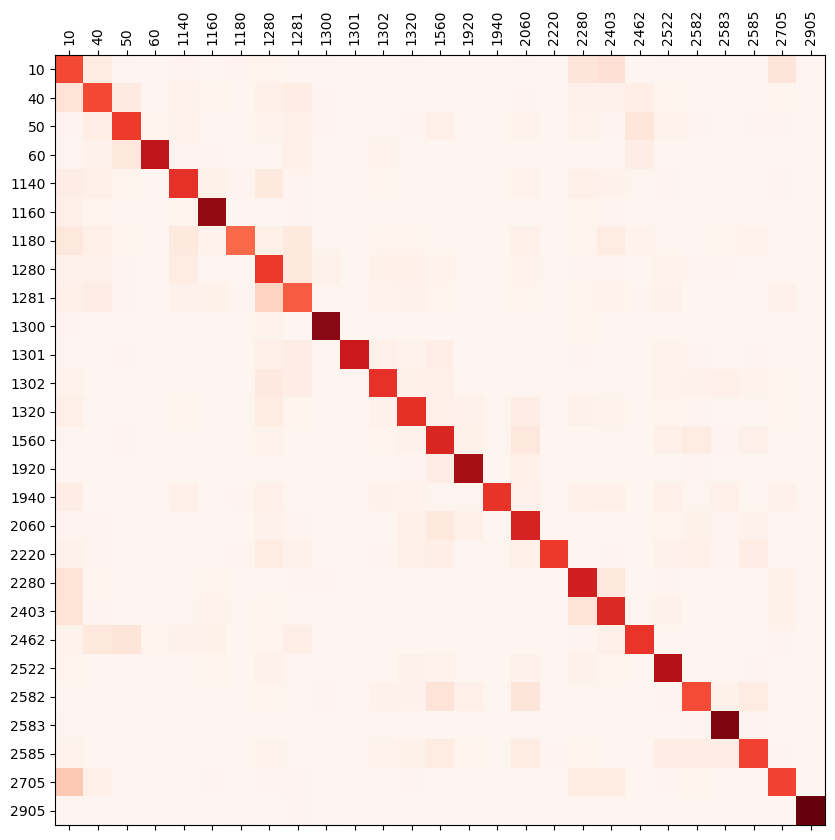

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
cm_normalized = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis])
#cm_normalized=cm.div(cm.sum(axis=1), axis=0)
cax = ax.matshow(cm_normalized, cmap='Reds')
plt.xticks(range(27),catdict,rotation=90)
plt.yticks(range(27),catdict,rotation=0)
plt.show()

## Etude des catégories 10 ; 2280 ; 2403 ; 2705

In [ ]:
df_livres=df_test[df_test['prdtypecode'].isin([10,2280,2403,2705])]
vectorizer=text_clf.named_steps['tfidf']
df_livres.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3389 entries, 3 to 18679
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      3389 non-null   int64 
 1   designation     3389 non-null   object
 2   description     569 non-null    object
 3   productid       3389 non-null   int64 
 4   imageid         3389 non-null   int64 
 5   PAYS_LANGUE     3389 non-null   object
 6   design_descrip  3389 non-null   object
 7   phrases         3389 non-null   object
 8   prdtypecode     3389 non-null   int64 
 9   predict         3389 non-null   int64 
dtypes: int64(5), object(5)
memory usage: 291.2+ KB


### Tableau des repartitions des **classes predites** pour chaque `classe réelle`

In [ ]:
for c in [10,2280,2403,2705]:
    print(c,'   ------   ', catdict[c] )
    print(df_livres[df_livres['prdtypecode']==c]['predict'].value_counts(normalize=True)[:5])

10    ------    livres
predict
10      0.570803
2403    0.110949
2705    0.091971
2280    0.090511
40      0.055474
Name: proportion, dtype: float64
2280    ------    magazines
predict
2280    0.708691
10      0.106017
2403    0.075454
2705    0.025788
40      0.014327
Name: proportion, dtype: float64
2403    ------    livres et bds
predict
2403    0.666667
2280    0.103810
10      0.100952
2705    0.024762
2522    0.021905
Name: proportion, dtype: float64
2705    ------    bds et livres
predict
2705    0.588138
10      0.196046
2403    0.052718
2280    0.051071
40      0.032949
Name: proportion, dtype: float64


### Les 10 mots ayant le **scores TF-IDF** les plus élévés et ceux des rangs de 76 à 80.   
Ces scores aident à identifier les mots qui sont importants dans un document particulier en tenant compte  
de leur fréquence dans ce document et de leur rareté dans l'ensemble du corpus.

In [ ]:
Words = vectorizer.transform(df_livres['designation'])
#help(CountVectorizer)
words = vectorizer.get_feature_names_out()
word_counts = Words.sum(axis=0)
word_count_dict = dict(zip(words, word_counts.tolist()[0]))
#print(word_count_dict)
occurrences_triees = sorted(word_count_dict.items(), key=lambda x: x[1], reverse=True)[:80]
Dic_words={}
for item in occurrences_triees:
    #print(item[0], ":", item[1])
    Dic_words[item[0]]=item[1]
#print(Dic_words)
df_words=pd.DataFrame.from_dict(Dic_words, orient='index',columns=['Total'])
print(df_words.head(10))
print(df_words.tail())

              Total
lot       93.297337
tome      56.344146
livres    51.999364
01        40.179128
10        38.497605
12        32.783278
11        30.922111
france    30.095782
revue     29.677567
magazine  29.114804
              Total
piano      7.124548
24         7.036313
avril      6.973697
album      6.967048
intégrale  6.873213


### Les 20 mots ayant le **scores TF-IDF** les plus élévés .

In [ ]:
df_total_livres=df_words
words = vectorizer.get_feature_names_out()
for c in [10,2705,2280,2403]:
    X_words = vectorizer.transform(df_livres[df_livres['prdtypecode']==c] ['designation'])
    word_counts = X_words.sum(axis=0)
    word_count_dict = dict(zip(words, word_counts.tolist()[0]))
    occurrences_triees = sorted(word_count_dict.items(), key=lambda x: x[1], reverse=True)[:20]
    Dic_words={}
    for item in occurrences_triees:
        Dic_words[item[0]]=item[1]
    df_words_X=pd.DataFrame.from_dict(Dic_words, orient='index',columns=[str(c)])
    df_total_livres=df_total_livres.join(df_words_X)
df_total_livres.head(20)

,Total,10,2705,2280,2403
lot,93.297337,NaN,NaN,NaN,92.158471
tome,56.344146,11.650113,21.940619,NaN,21.325055
livres,51.999364,NaN,NaN,NaN,50.275812
01,40.179128,NaN,NaN,36.974804,NaN
10,38.497605,NaN,NaN,19.536979,16.409545
12,32.783278,NaN,NaN,19.277957,12.077328
11,30.922111,3.646027,NaN,20.438734,NaN
france,30.095782,3.912862,NaN,14.726065,9.712943
revue,29.677567,NaN,NaN,16.593297,11.865593
magazine,29.114804,NaN,NaN,20.411596,NaN


### Heatmap couleur Rouge foncée : fréquence très élévée
couleur Bleu foncée : fréquance très basse
couleur Blanche : NaN

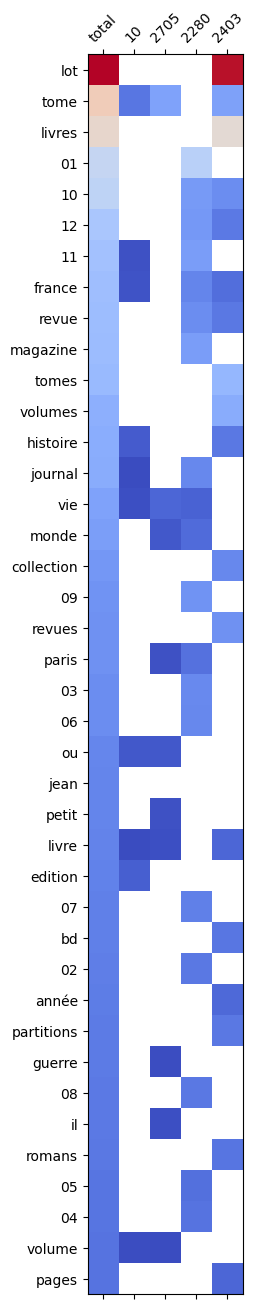

In [ ]:
fig, ax = plt.subplots(figsize=(2,20))
cax = ax.matshow(df_total_livres.iloc[0:40], cmap = 'coolwarm')
plt.xticks(range(5),('total','10','2705','2280','2403'),rotation=45)
plt.yticks(range(40),df_total_livres.iloc[0:40].index,rotation=0)
plt.show()

## Etude des catégories 1280,1281

In [ ]:
df_jouets=df_test[df_test['prdtypecode'].isin([1280,1281])]

### Tableau des repartitions des **classes predites** pour chaque `classe réelle`

In [ ]:
for c in [1280,1281]:
    print(c,'   ------   ', catdict[c] )
    print(df_jouets[df_jouets['prdtypecode']==c]['predict'].value_counts(normalize=True)[:5])

1280    ------    jouets, peluches, poupees
predict
1280    0.614379
1281    0.072829
1140    0.060691
1320    0.027077
1302    0.025210
Name: proportion, dtype: float64
1281    ------    jeux de societe/cartes
predict
1281    0.523077
1280    0.160440
40      0.048352
10      0.028571
1160    0.026374
Name: proportion, dtype: float64


### Les 10 mots ayant le **scores TF-IDF** les plus élévés et ceux des rangs de 76 à 80.   
Ces scores aident à identifier les mots qui sont importants dans un document particulier en tenant compte  
de leur fréquence dans ce document et de leur rareté dans l'ensemble du corpus.

In [ ]:
Words = vectorizer.transform(df_jouets['designation'])
#help(CountVectorizer)
words = vectorizer.get_feature_names_out()
word_counts = Words.sum(axis=0)
word_count_dict = dict(zip(words, word_counts.tolist()[0]))
#print(word_count_dict)
occurrences_triees = sorted(word_count_dict.items(), key=lambda x: x[1], reverse=True)[:80]
Dic_words={}
for item in occurrences_triees:
    #print(item[0], ":", item[1])
    Dic_words[item[0]]=item[1]
#print(Dic_words)
df_words=pd.DataFrame.from_dict(Dic_words, orient='index',columns=['Total'])
print(df_words.head(10))
print(df_words.tail())

             Total
enfants  45.267651
jouet    37.558010
peluche  35.140603
jouets   34.989406
toy      32.252619
doudou   30.234269
puzzle   27.056359
jeu      23.825432
bébé     21.655558
cadeau   21.282932
                  Total
développement  5.803189
boule          5.802947
simulé         5.781250
musique        5.724818
jouer          5.718962


### Les 20 mots ayant le **scores TF-IDF** les plus élévés .  

In [ ]:
df_total_jouets=df_words
words = vectorizer.get_feature_names_out()
for c in [1280,1281]:
    X_words = vectorizer.transform(df_jouets[df_jouets['prdtypecode']==c] ['designation'])
    word_counts = X_words.sum(axis=0)
    word_count_dict = dict(zip(words, word_counts.tolist()[0]))
    occurrences_triees = sorted(word_count_dict.items(), key=lambda x: x[1], reverse=True)[:20]
    Dic_words={}
    for item in occurrences_triees:
        Dic_words[item[0]]=item[1]
    df_words_X=pd.DataFrame.from_dict(Dic_words, orient='index',columns=[str(c)])
    df_total_jouets=df_total_jouets.join(df_words_X)
df_total_jouets.head(20)

,Total,1280,1281
enfants,45.267651,33.080509,12.187142
jouet,37.558010,29.292394,8.265616
peluche,35.140603,32.579356,NaN
jouets,34.989406,26.024941,8.964465
toy,32.252619,22.019574,10.233046
doudou,30.234269,30.234269,NaN
puzzle,27.056359,22.612416,4.443943
jeu,23.825432,NaN,19.169829
bébé,21.655558,14.665426,6.990132
cadeau,21.282932,15.821260,5.461672


###**Heatmap**
couleur Rouge foncée : fréquence très élévée  
couleur Bleu foncée : fréquance très basse  
couleur Blanche : NaN  

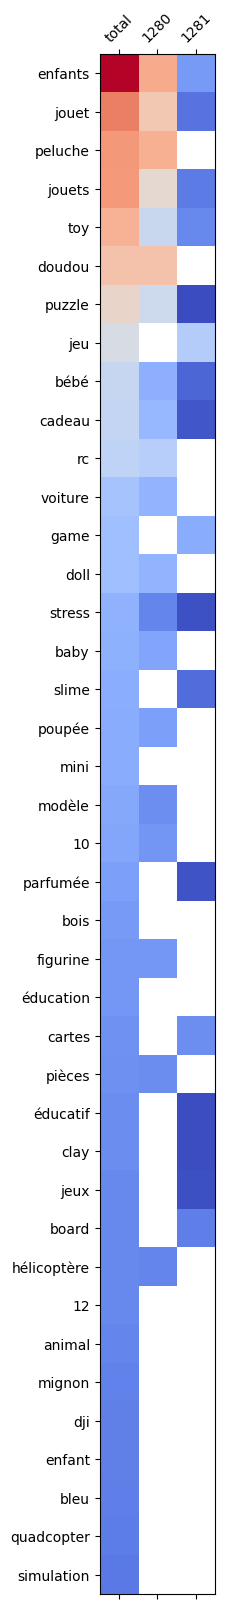

In [ ]:
fig, ax = plt.subplots(figsize=(2,20))
cax = ax.matshow(df_total_jouets.iloc[0:40], cmap = 'coolwarm')
plt.xticks(range(3),('total','1280','1281'),rotation=45)
plt.yticks(range(40),df_total_jouets.iloc[0:40].index,rotation=0)
plt.show()